In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import pandas as pd
import shapely
import numpy as np
import seaborn as sns
import random


%matplotlib inline

## load in data

In [2]:
all_17 = gpd.read_file('../../Data/mtl_trajet/mtl_trajet_2017_final.shp')

In [3]:
# turn these new columns into datetime objects
all_17['starttime'] = pd.to_datetime(all_17['starttime'])
all_17['endtime'] = pd.to_datetime(all_17['endtime'])

## calculate data for average nearby purpose proportions

In [4]:
def calculate_average_nearby_purposes(data, purpose_type, buffer_size_m):
    """
        function for calculating average nearby trip purposes based on a buffer size and a given purpos type
    """
    data['geometry'] = data.apply(lambda row: shapely.geometry.Point(row['endx'],row['endy']),axis=1)
    geo_data = gpd.GeoDataFrame(data,crs="EPSG:3347")
    # calculate X m buffers around each trip end point
    geo_data['buffers'] = geo_data['geometry'].apply(lambda row: row.buffer(buffer_size_m))
    # get a geo-dataframe with only the Trip ID,trip end buffer and trip purpose
    only_buffers = geo_data.loc[geo_data.purpose == purpose_type][['id_trip','buffers']]
    only_buffers = gpd.GeoDataFrame(only_buffers.rename(columns={'buffers':'geometry'}), crs="EPSG:3347")
    
    joined_data = gpd.sjoin(only_buffers, geo_data, op='intersects', how='left')

    ## drop duplicates (as each trip will fall within a buffer of itself)
    to_drop = joined_data[['id_trip_left','id_trip_right']].apply(lambda row: True \
                                                                if row['id_trip_left'] == row['id_trip_right']\
                                                                else False, axis=1)
    joined_data = joined_data[~to_drop]
    
    ## Compute the proportion of nearby purposes types for each trip/row
    grouped_data = joined_data.groupby(['id_trip_left', 'purpose']).agg({'mode':'count'})
    grouped_data = grouped_data.unstack().apply(lambda row: row/row.sum(),axis=1)['mode'].reset_index()*100
    grouped_data = grouped_data.fillna(0.0)
    return grouped_data[[0,1,2,3,4,5]].mean().values

In [5]:
%%time
ALL_AVERAGE_NEARBY_PURPOSES = {}
all_buffers = [50,100,150,200,250,300,350,400]
all_purposes = [0,1,2,3,4,5]
for buffer_size in all_buffers:
    for pur in all_purposes:
        print(buffer_size, pur)
        vals = calculate_average_nearby_purposes(data=all_17, purpose_type=pur, buffer_size_m=buffer_size)
        ALL_AVERAGE_NEARBY_PURPOSES[str(pur)+str(buffer_size)] = vals.tolist()

50 0
50 1
50 2
50 3
50 4
50 5
100 0
100 1
100 2
100 3
100 4
100 5
150 0
150 1
150 2
150 3
150 4
150 5
200 0
200 1
200 2
200 3
200 4
200 5
250 0
250 1
250 2
250 3
250 4
250 5
300 0
300 1
300 2
300 3
300 4
300 5
350 0
350 1
350 2
350 3
350 4
350 5
400 0
400 1
400 2
400 3
400 4
400 5
CPU times: user 6min 29s, sys: 3.34 s, total: 6min 33s
Wall time: 6min 32s


In [6]:
all_av_np_df = pd.DataFrame.from_dict(ALL_AVERAGE_NEARBY_PURPOSES)

In [7]:
# view data
all_av_np_df

,050,150,250,350,450,550,0100,1100,2100,3100,...,2350,3350,4350,5350,0400,1400,2400,3400,4400,5400
0,48.427927,31.976453,25.999223,29.519332,17.862159,30.593658,46.547046,32.201711,27.333097,30.993885,...,29.560636,33.800409,25.035613,32.585115,41.469795,33.198026,29.832844,33.975181,25.871792,32.818193
1,11.879590,22.942372,11.944393,9.249496,6.950745,10.359029,11.798634,21.010574,12.326725,9.339247,...,12.331573,10.308804,9.546457,10.942109,11.763534,16.213800,12.295405,10.526266,9.680070,11.129491
2,25.147585,31.141592,50.728337,22.966770,11.584660,27.586944,26.127283,32.406382,48.267984,24.095995,...,43.266828,28.718998,17.311116,29.692269,28.603078,33.053068,42.631911,29.176692,18.222387,30.072047
3,4.824992,4.066019,3.850639,27.598415,3.173349,5.544743,5.223635,4.236587,4.208431,24.238573,...,5.207211,15.216531,3.995964,6.368295,5.911416,5.110296,5.309205,14.565024,3.972361,6.308567
4,6.159312,6.568410,4.138868,6.717411,58.079159,7.123349,6.676328,6.746397,4.475387,6.894227,...,5.983926,7.485606,41.039431,8.763830,8.395022,8.847594,6.259695,7.357384,39.194726,8.839120
5,3.560593,3.305155,3.338540,3.948576,2.349929,18.792277,3.627074,3.398350,3.388376,4.438072,...,3.649826,4.469652,3.071419,11.648382,3.857155,3.577214,3.670940,4.399454,3.058665,10.832582


In [8]:
## save data
# pd.DataFrame.from_dict(ALL_AVERAGE_NEARBY_PURPOSES).to_csv('all_average_nearby_purposes.csv',index=False)

## create visualisation

In [9]:
def get_slice(data, pur, other_pur):
#     other_pur = pur + num_away % 6
    return all_av_np_df[str(other_pur)+'50'][pur], all_av_np_df[str(other_pur)+'100'][pur],\
            all_av_np_df[str(other_pur)+'150'][pur],all_av_np_df[str(other_pur)+'200'][pur],\
            all_av_np_df[str(other_pur)+'250'][pur],all_av_np_df[str(other_pur)+'300'][pur],\
            all_av_np_df[str(other_pur)+'350'][pur],all_av_np_df[str(other_pur)+'400'][pur]


In [10]:
# test get slice function
get_slice(all_av_np_df, 0, 0)

(48.42792734036415,
 46.54704623759209,
 45.672667291151015,
 44.71892843448574,
 43.63333387439377,
 42.71957570428986,
 41.98450910708149,
 41.46979483319099)

In [11]:
def create_x_coords(start_val, number_vals):
    coords = []
    current_val = start_val
    for i in range(number_vals):
        coords.append(current_val)
        current_val += 0.5
    return coords

# Visualize!

In [12]:
x_ticks = []

for num in np.arange(0,30, 5):
    x_ticks.extend(create_x_coords(start_val=num, number_vals=8))

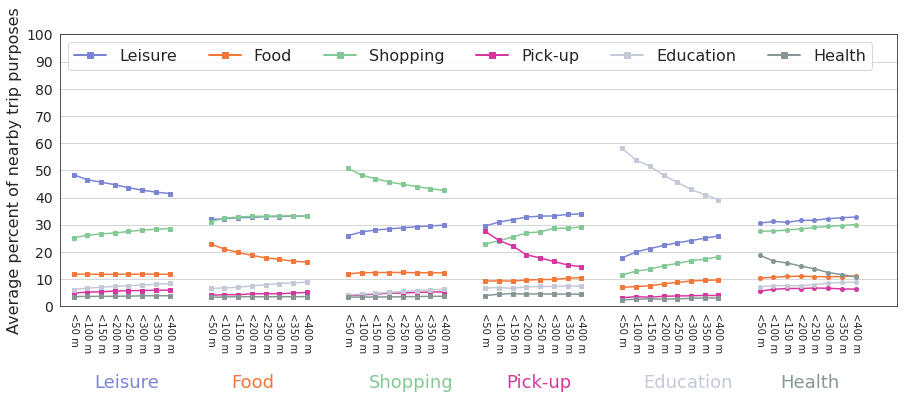

In [13]:
sns.set_style('white')
fig, ax = plt.subplots(1, figsize=(15,5))
# markers = ['$L$','$S$','$C$','$P$','$E$','$H$']
LONG_NAMES = ['Leisure','Food','Shopping','Pick-up','Education','Health']
COLOURBLIND_PALETTE = ["#7b85d4","#f37738","#83c995","#d7369e","#c4c9d8","#859795","#e9d043","#ad5b50", "#ffa07a", "k"]
# markers = ['o','v','*','s','P','D']
# for i in range(6):
#     ax.scatter(*create_x_y(), marker=markers[i], c=COLOURBLIND_PALETTE[i],alpha=.75, s=100)
for i in range(6):
    ax.plot(create_x_coords(start_val=0, number_vals=8),get_slice(all_av_np_df, i, 0),
           marker='s', markersize=4,c=COLOURBLIND_PALETTE[i])
    ax.plot(create_x_coords(start_val=5, number_vals=8),get_slice(all_av_np_df, i, 1),
           marker='s', markersize=4,c=COLOURBLIND_PALETTE[i])
    ax.plot(create_x_coords(start_val=10, number_vals=8),get_slice(all_av_np_df, i, 2),
           marker='s', markersize=4,c=COLOURBLIND_PALETTE[i])
    ax.plot(create_x_coords(start_val=15, number_vals=8),get_slice(all_av_np_df, i, 3),
           marker='s', markersize=4,c=COLOURBLIND_PALETTE[i])
    ax.plot(create_x_coords(start_val=20, number_vals=8),get_slice(all_av_np_df, i, 4),
           marker='s', markersize=4,c=COLOURBLIND_PALETTE[i])
    ax.plot(create_x_coords(start_val=25, number_vals=8),get_slice(all_av_np_df, i, 5),
           marker='o', markersize=4,c=COLOURBLIND_PALETTE[i])
    
legend_elements = [Line2D([0], [0], color=COLOURBLIND_PALETTE[i],marker='s', lw=2,) for i in range(len(COLOURBLIND_PALETTE))]

plt.xlim(-0.5,30)
plt.ylim(0,100)
plt.xticks(x_ticks, ['<50 m','<100 m','<150 m', '<200 m','<250 m','<300 m','<350 m','<400 m']*6,fontsize=10, rotation=-90);
plt.yticks(np.arange(0,101,10),size=14)
plt.ylabel("Average percent of nearby trip purposes", size=16)
to_add = 5
value = 0
for i, nm in enumerate(LONG_NAMES):
    plt.text(value+0.75,-30, nm, c=COLOURBLIND_PALETTE[i],size=18)
    value+=to_add
ax.grid(axis='y')
ax.legend(legend_elements, LONG_NAMES,fontsize=16, loc='upper left', ncol=len(LONG_NAMES), fancybox=True)
# plt.savefig('../../other/images/average_nearby_trip_purposes.tif',bbox_inches='tight', dpi = 300)

In [14]:
??ax.legend